### HybridAStar::Plan
代码对应入口:[hybrid_a_star.h](https://github.com/ApolloAuto/apollo/blob/master/modules/planning/open_space/coarse_trajectory_generator/hybrid_a_star.h)

应用:用于泊车/靠边停车场景

调用关系:在OpenSpace Planner中调用

输入:(标准化处理后的)起点和终点,需要x,y和phi

输出:(未经平滑的)路径

#### 简单原理
根据起点终点生成DP Map(参照A* 用来加速)

遍历DP Map,使用RS曲线尝试连接终点,

连接成功则退出遍历,生成路径

连接失败则选择周围cost最高的点,继续遍历

---

/>>>>>>>>>>>>>>>>>>>>>>>>> ToDo:图

---


#### DreamView示意

使用 Sunnyvale with two office map中的11543车位

![img](./dreamview.png)

In [1]:
#初始化起点和终点
#这些输入是在OpenSpaceTrajectoryOptimizer::Plan函数中提前预处理好的

#标准化后的起点和终点:
sx = 1.658181
sy = 3.937398
sphi = 0.012450
ex = 1.359387
ey = -3.663455
ephi = 1.595447

#DP图的范围
XYbounds=[-13.6,16.2,-5.1,5.8]

##障碍物(车位边界也按障碍物来处理)
obstacles_vertices_vec = []
obstacles_vertices_vec.append([[-13.63,0,0.12],[-0.20,0,-5.15]])
obstacles_vertices_vec.append([[0.12,2.89],[-5.15,-5.11]])
obstacles_vertices_vec.append([[2.89,2.71,16.35],[-5.11,0,0.20]])
obstacles_vertices_vec.append([[16.27,-13.72],[5.84,5.41]])

##自车参数(Mkz Example)
ego_length = 4.93
ego_width = 2.10
back_edge_to_center = 1.043
shift_distance = ego_length / 2.0 - back_edge_to_center

##常量
kMathEpsilon = 1e-10

import matplotlib.pyplot as plt
import math
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111)

##画示意图
dx = 2 * math.cos(sphi)
dy = 2 * math.sin(sphi)

#蓝箭头表示起点方向
ax.arrow(sx,sy,dx,dy,length_includes_head=True,head_width=0.25, head_length=0.5, fc='r', ec='b')
dx = 2 * math.cos(ephi)
dy = 2 * math.sin(ephi)

#黑箭头表示终点方向
plt.arrow(ex,ey,dx,dy,length_includes_head=True,head_width=0.25, head_length=0.5, fc='r', ec='black')
ax.plot([sx,ex],[sy,ey],"ro")

#画出DP考虑的边界(蓝线)
ax.plot([XYbounds[0],XYbounds[1],XYbounds[1],XYbounds[0],XYbounds[0]],[XYbounds[2],XYbounds[2],XYbounds[3],XYbounds[3],XYbounds[2]])
ax.set_aspect('equal') #x轴y轴等比例

#画障碍物(边界,红线)
for obs in obstacles_vertices_vec:
    ax.plot(obs[0],obs[1],"r")
    
#画自车
dx1 = math.cos(sphi) * (ego_length / 2)
dy1 = math.sin(sphi) * (ego_length / 2)
dx2 = math.sin(sphi) * (ego_width / 2)
dy2 = -math.cos(sphi) * (ego_width / 2)

corner_x1 = sx + dx1 + dx2
corner_x2 = sx + dx1 - dx2
corner_x3 = sx - dx1 - dx2
corner_x4 = sx - dx1 + dx2
corner_y1 = sy + dy1 + dy2
corner_y2 = sy + dy1 - dy2
corner_y3 = sy - dy1 - dy2
corner_y4 = sy - dy1 + dy2
corner_x = [corner_x1,corner_x2,corner_x3,corner_x4,corner_x1]
corner_y = [corner_y1,corner_y2,corner_y3,corner_y4,corner_y1]
ax.plot(corner_x,corner_y)

dx1 = math.cos(ephi) * (ego_length / 2)
dy1 = math.sin(ephi) * (ego_length / 2)
dx2 = math.sin(ephi) * (ego_width / 2)
dy2 = -math.cos(ephi) * (ego_width / 2)

corner_x1 = ex + dx1 + dx2
corner_x2 = ex + dx1 - dx2
corner_x3 = ex - dx1 - dx2
corner_x4 = ex - dx1 + dx2
corner_y1 = ey + dy1 + dy2
corner_y2 = ey + dy1 - dy2
corner_y3 = ey - dy1 - dy2
corner_y4 = ey - dy1 + dy2
corner_x = [corner_x1,corner_x2,corner_x3,corner_x4,corner_x1]
corner_y = [corner_y1,corner_y2,corner_y3,corner_y4,corner_y1]
ax.plot(corner_x,corner_y)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [2]:
#这个在配置文件中
xy_grid_resolution_ = 0.5 #单元格的大小
node_radius_ = 0.6

##一些基础类
class Node3d:
    def __init__(self, x, y, phi = 0.0, cost = 0.0 , pre_node = None):
        self.x = x
        self.y = y
        self.phi = phi
        self.cost = cost
        self.pre_node = pre_node
        self.grid_x = (int)((x - XYbounds[0]) / xy_grid_resolution_)
        self.grid_y = (int)((y - XYbounds[2]) / xy_grid_resolution_)
        self.index = str(self.grid_x) + "_" + str(self.grid_y) + "_" + str(self.phi)
        
    def SetPreNode(self,pre_node):
        self.pre_node = pre_node
        
#点到segment的距离
def PtSegDistance(query_x,query_y,start_x,start_y,end_x,end_y,length)->float:
    x0 = query_x - start_x
    y0 = query_y - start_y
    dx = end_x - start_x
    dy = end_y - start_y
    proj = x0 * dx + y0 * dy
    if proj <= 0.0:
        return math.hypot(x0,y0)
    if proj >= length * length:
        return math.hypot(x0-dx,y0-dy)
    return abs(x0*dy - y0*dx) / length

def CrossProd(sx,sy,ex1,ey1,ex2,ey2) -> float:
    dx1 = ex1-sx
    dy1 = ey1-sy
    dx2 = ex2-sx
    dy2 = ey2-sy
    return dx1 * dy2 - dy1 * dx2

#LineSegment2d::Distanceto
def LineSegmentDistance(sx,sy,ex,ey,x2,y2) -> float:
    length = math.hypot((ex-sx),(ey-sy))
    if(length < kMathEpsilon):
        return math.hypot((x2-sx),(y2-sy))
    x0 = x2 - sx
    y0 = y2 - sy
    dx = ex - sx
    dy = ey - sy
    unit_direction_ = [dx / length,dy / length]
    proj = x0 * unit_direction_[0] + y0 * unit_direction_[1]
    if(proj <= 0.0):
        return math.hypot(x0,y0)
    if(proj >= length):
        return math.hypot(x2-ex,y2-ey)
    return abs(x0 * unit_direction_[1] - y0 * unit_direction_[0])
    
        
class Box2d:
    def __init__(self, x, y, heading, length, width):
        self.x = x
        self.y = y
        self.length = length
        self.width = width
        self.heading = heading
        self.cos_heading_ = math.cos(heading)
        self.sin_heading_ = math.sin(heading)
        
        #Box2d::InitCorners()
        dx1 = math.cos(heading) * (ego_length / 2)
        dy1 = math.sin(heading) * (ego_length / 2)
        dx2 = math.sin(heading) * (ego_width / 2)
        dy2 = -math.cos(heading) * (ego_width / 2)

        self.corner_x1 = sx + dx1 + dx2
        self.corner_x2 = sx + dx1 - dx2
        self.corner_x3 = sx - dx1 - dx2
        self.corner_x4 = sx - dx1 + dx2
        self.corner_y1 = sy + dy1 + dy2
        self.corner_y2 = sy + dy1 - dy2
        self.corner_y3 = sy - dy1 - dy2
        self.corner_y4 = sy - dy1 + dy2
        self.max_x = max(corner_x1,corner_x2,corner_x3,corner_x4)
        self.min_x = min(corner_x1,corner_x2,corner_x3,corner_x4)
        self.max_y = max(corner_y1,corner_y2,corner_y3,corner_y4)
        self.min_y = min(corner_y1,corner_y2,corner_y3,corner_y4)
    
        
    def HasOverlap(self,sx,sy,ex,ey) -> bool:
        #AABB
        if(max(sx,ex) < self.min_x or min(sx,ex) > self.max_x or max(sy,ey) < self.min_y or min(sy,ey) > self.max_y):
            return False
        else :
            return self.DistanceTo(sx,sy,ex,ey) <= kMathEpsilon
        
    def DistanceTo(self,sx,sy,ex,ey) -> float: 
        segment_length = math.hypot((ex-sx),(ey-sy))
        
        ref_x1 = sx - self.x
        ref_y1 = sy - self.y
        x1 = ref_x1 * self.cos_heading_+ ref_y1 * self.sin_heading_
        y1 = ref_x1 * self.sin_heading_ - ref_y1 * self.cos_heading_
        box_x = self.length /2
        box_y = self.width /2
        gx1 = 1 if x1>=box_x else (-1 if x1 <=-box_x else 0)
        gy1 = 1 if y1>=box_y else (-1 if y1 <=-box_y else 0)
        if gx1 == 0 and gy1 == 0:
            return 0.0
        
        ref_x2 = ex - self.x
        ref_y2 = ey - self.y
        x2 = ref_x2 * self.cos_heading_+ ref_y2 * self.sin_heading_
        y2 = ref_x2 * self.sin_heading_ - ref_y2 * self.cos_heading_
        gx2 = 1 if x2>=box_x else (-1 if x2 <=-box_x else 0)
        gy2 = 1 if y2>=box_y else (-1 if y2 <=-box_y else 0)
        if gx1 == 0 and gy1 == 0:
            return 0.0
        
        #不懂 再研究吧

        if gx1 < 0 or (gx1 == 0 and gx2 <0):
            x1,x2,gx1,gx2 = -x1,-x2,-gx1,-gx2
        if gy1 < 0 or (gy1 == 0 and gy2 < 0):
            y1,y2,gy1,gy2 = -y1,-y2,-gy1,-gy2
        if gx1 < gy1 or (gx1 == gy1 and gx2 < gy2):
            x1,gx1,x2,gx2,box_x = y1,gy1,y2,gy2,box_y
            
        #这更看不懂了
        if gx1 == 1 and gy1 == 1:
            res = gx2 * 3 + gy2
            if res == 4:
                return PtSegDistance(box_x,box_y,x1,y1,x2,y2,segment_length)
            elif res == 3:
                return x2-box_x if x1>x2 else PtSegDistance(box_x,box_y,x1,y1,x2,y2,segment_length)
            elif res == 2:
                return PtSegDistance(box_x,-box_y,x1,y1,x2,y2,segment_length) if x1>x2 else PtSegDistance(box_x,box_y,x1,y1,x2,y2,segment_length)
            elif res == -1:
                return 0.0 if CrossProd(x1,y1,x2,y2,box_x,-box_y) >= 0.0 else PtSegDistance(box_x,-box_y,x1,y1,x2,y2,segment_length)
            elif res == -4:
                return PtSegDistance(box_x,-box_y,x1,y1,x2,y2,segment_length) if CrossProd(x1,y1,x2,y2,box_x,-box_y) <= 0.0 else(0.0 if CrossProd(x1,y1,x2,y2,-box_x,box_y) <= 0.0 else PtSegDistance(-box_x,box_y,x1,y1,x2,y2,segment_length))
        else:
            res = gx2 * 3 + gy2
            if res == 4:
                return x1 - box_x if x1 < x2 else PtSegDistance(box_x,box_y,x1,y1,x2,y2,segment_length)
            elif res == 3:
                return math.min(x1,x2) - box_x
            elif (res == 1 or res == -2):
                return 0.0 if CrossProd(x1,y1,x2,y2,box_x,box_y) <= 0.0 else PtSegDistance(box_x,box_y,x1,y1,x2,y2,segment_length)
            elif res == -3:
                return 0.0
            
        return 0.0    

In [3]:
# HybridAstar::ValidityCheck
def ValidityCheck(node:Node3d,obstacle_linesegments) -> bool:
    if len(obstacle_linesegments) == 0:
        return True
    if node.x > XYbounds[1] or node.x < XYbounds[0] or node.y > XYbounds[3] or node.y < XYbounds[2] :
        print(node.x,node.y)
        print(XYbounds)
        return False
    
    box = Box2d(node.x + shift_distance*math.cos(node.phi),node.y + shift_distance*math.sin(node.phi),node.phi,ego_length,ego_width)
    
    for linesegments in obstacle_linesegments:
        sx = linesegments[0][0]
        sy = linesegments[0][1]
        ex = linesegments[1][0]
        ey = linesegments[1][1]
        if(box.HasOverlap(sx,sy,ex,sy)):
            return False

In [4]:
def calc_heuristic(n1, n2):
    w = 1.0  # weight of heuristic
    d = w * math.hypot(n1.x - n2.x, n1.y - n2.y)
    return d

def get_motion_model():
    # dx, dy, cost
    motion = [[xy_grid_resolution_, 0, 1],
              [0, xy_grid_resolution_, 1],
              [-xy_grid_resolution_, 0, 1],
              [0, -xy_grid_resolution_, 1],
              [-xy_grid_resolution_, -xy_grid_resolution_, math.sqrt(2)],
              [-xy_grid_resolution_, xy_grid_resolution_, math.sqrt(2)],
              [xy_grid_resolution_, -xy_grid_resolution_, math.sqrt(2)],
              [xy_grid_resolution_, xy_grid_resolution_, math.sqrt(2)]]

    return motion


def GenerateDpMap(start_node,end_node,XYbounds,obstacle_linesegments):
    #替代GenerateNextNodes函数
    motions = get_motion_model()
    
    
    
    #HybridAStar::GenerateDpMap
    open_set,dp_map_,open_pq = dict(),dict(),dict()
    
    max_grid_y_ = round((XYbounds[3] - XYbounds[2]) / xy_grid_resolution_)
    max_grid_x_ = round((XYbounds[1] - XYbounds[0]) / xy_grid_resolution_)

    end_node_ = Node3d(x = end_node.x,y = end_node.y) # 3d to 2d node
    open_pq[end_node.index] = end_node_
    open_set[end_node.index] = end_node_
    
    #plot
    fig = plt.figure(figsize=(12,8)  , dpi=100)
    ax1 = fig.add_subplot(111)
    x_data,y_data,cost_data = [end_node.x],[end_node.y],[end_node.cost]
    
    
    #Grid a star begins
    while len(open_pq) != 0:
        #current_id = max(open_pq,key=lambda o: open_pq[o].cost + calc_heuristic(start_node,open_pq[o]))
        current_id = min(open_pq,key=lambda o: open_pq[o].cost)
        del open_pq[current_id]
        current_node = open_set[current_id]
        dp_map_[current_id] = current_node
        #print("id",current_id,"\tcost:",current_node.cost)

        #GenerateNextNodes
        for i,motion in enumerate(motions):
            node = Node3d(x = current_node.x + motion[0], 
                          y = current_node.y + motion[1], 
                          cost = current_node.cost + motion[2], 
                          pre_node = current_node)
            
            # GridSearch::CheckConstraints
            if node.grid_x > max_grid_x_ or node.grid_x < 0 or node.grid_y > max_grid_y_ or node.grid_y < 0:
                continue
                
            collisionFlag = False
            if len(obstacle_linesegments) != 0:
                for linesegments in obstacle_linesegments:
                    sx = linesegments[0][0]
                    sy = linesegments[0][1]
                    ex = linesegments[1][0]
                    ey = linesegments[1][1]
                    if(LineSegmentDistance(sx,sy,ex,ey,node.x,node.y) < node_radius_):
                        collisionFlag = True
                        break
            if collisionFlag:
                continue
                
            # Already calc in dp_map
            if node.index in dp_map_.keys():
                continue
                
            # find a new node
            if node.index not in open_set.keys():
                node.SetPreNode(current_node)
                open_set[node.index] = node
                open_pq[node.index] = node
            else:#not a new node
                if open_set[node.index].cost > node.cost:
                    node.SetPreNode(current_node)
                    del open_set[node.index]
                    open_set[node.index] = node
        
#plot open_set
    for node in open_set.values():
        #print("add:",node.grid_x,node.grid_y,node.cost,node.x,node.y)
        x_data.append(node.x)
        y_data.append(node.y)
        cost_data.append(round(node.cost,1))
        
    ax1.plot(x_data,y_data,"o",markersize=3.0)
    for i in range(0,len(x_data)):
        ax1.text(x_data[i], y_data[i], cost_data[i],fontsize=5)
            

In [5]:
#RS
#max_kappa = tan(max_steer_angle / steer_ratio) / wheel_base
max_kappa = 0.1984

def NormalizeAngle(phi):
    a = math.fmod(phi + math.pi,2.0 * math.pi)
    if a < 0.0:
        a += 2.0 * math.pi
    return a - math.pi

class Path:

    def __init__(self):
        self.seg_length = []
        self.seg_types = []
        self.total_length = 0.0
        self.x = []
        self.y = []
        self.phi = []
        self.gear = []
        
def set_path(paths, lengths, ctypes):
    path = Path()
    path.seg_types = ctypes
    path.lengths = lengths

    # check same path exist
    for tpath in paths:
        typeissame = (tpath.ctypes == path.ctypes)
        if typeissame:
            if sum(np.abs(tpath.lengths)) - sum(np.abs(path.lengths)) <= 0.01:
                return paths  # not insert path

    path.L = sum([abs(i) for i in lengths])

    # Base.Test.@test path.L >= 0.01
    if path.L >= 0.01:
        paths.append(path)

    return paths


# def SLS(x,y,phi):
#     phi_mod = NormalizeAngle(phi)
#     xd,u,t,v, = 0.0,0.0,0.0,0.0
#     if y > 0.0 and phi_mod > kMathEpsilon and phi_mod < math.pi:
#         xd = -y / math.tan(phi_mod) + x
#         t = xd - math.tan(phi_mod / 2.0)
#         u = phi_mod
#         v = math.sqrt((x - xd) * (x - xd) + y*y) - tan(phi_mod / 2.0)
#         return True,u,t,v
#     elif y < 0.0 && phi_mod > kMathEpsilon 
#         xd = -y / math.tan(phi_mod) + x
#         t = xd - tan(phi_mod / 2.0)
#         u = phi_mod
#         v = -math.sqrt((x - xd) * (x - xd) + y*y) - tan(phi_mod / 2.0)
#         return True,u,t,v
#     return False,u,t,v
    


In [6]:
def GenerateRSP(start_node,end_node):
    dx = end_node.x - start_node.x
    dy = end_node.y - start_node.y
    dphi = end_node.phi - start_node.phi
    c = math.cos(start_node.phi)
    s = math.sin(start_node.sin)
    # normalize the initial point to 0,0,0
    x = (c * dx + s * dy) * max_kappa
    y = (-s * dx + c * dy) * max_kappa
    
def ShortestRSP(current_node,end_node):
    return False

def AnalyticExpansion(current_node,end_node) -> bool:
    return False

In [7]:
#### RS


In [8]:
#HybridAStar::Plan
def Plan():
    #将obs转成line_segments的集合
    #line_segments:[[[x0,y0],[x1,y1]],[[x1,y1],[x2,y2]]]...
    obstacle_linesegments=[]
    for obs in obstacles_vertices_vec:
        vertices_num = len(obs[0])
        for i in range(0,vertices_num-1):
            obstacle_linesegments.append([[obs[0][i],obs[1][i]],[obs[0][i+1],obs[1][i+1]]])

    #print(obstacle_linesegments)        
    start_node = Node3d(sx,sy,sphi)
    end_node = Node3d(ex,ey,ephi)

    if ValidityCheck(start_node,obstacle_linesegments) == False:
        print("Start node is not valid")
        return
    if ValidityCheck(end_node,obstacle_linesegments) == False:
        print("End node is not valid")
        return
    
    #计算Map中各点到终点的距离,用于Hybrid A star加速
    GenerateDpMap(start_node,end_node,XYbounds,obstacle_linesegments)
    
    #Hybrid A* begins
    open_set,open_pq = dict()
    
    open_pq[start_node.index] = start_node
    open_set[start_node.index] = start_node
    while len(open_pq) != 0:
        #取当前cost最小的node
        current_id = min(open_pq,key=lambda o: open_pq[o].cost)
        del open_pq[current_id]
        current_node = open_set[current_id]
        
        #如果当前node到终点可以直接生成RS曲线,搜索中止
        if(AnalyticExpansion(current_node,end_node)):
            break
        
        


In [32]:
import matplotlib.pyplot as plt
import math

x1 = 1
y1 = 1
theta1 = 0
x2 = 10
y2 = 10
theta2 = 0

(-0.6363961030678928, 13.364318164425748, -0.5000000000000009, 10.5)

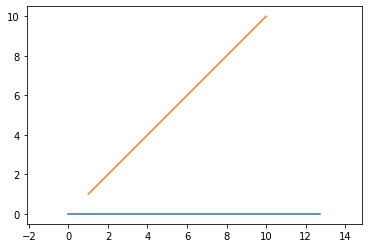

In [35]:
#画
phi = math.atan2(x2-x1,y2-y1)
x_diff = x2 - x1
y_diff = y2 - y1
dx1 = math.cos(phi) * (y_diff)
dy1 = math.sin(phi) * (y_diff)
dx2 = math.sin(phi) * (x_diff)
dy2 = -math.cos(phi) * (x_diff)

corner_x1 = dx1 + dx2
corner_y1 = dy1 + dy2

corner_x = [0,corner_x1]
corner_y = [0,corner_y1]

res_x = [x1,x2]
res_y = [y1,y2]

plt.plot(corner_x,corner_y)
plt.plot(res_x,res_y)
plt.axis("equal")

-12.294228634059948